# 0. Quick import

In [1]:
%load_ext autoreload
%autoreload 2

import os
print(os.getcwd())

/scratch3/zha439/REPA


In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.data import DataLoader
from PIL import Image
from dataclasses import dataclass
from models.sit import SiT_models
from metrics import AlignmentMetrics
from diffusers import AutoencoderKL
from dataset import CustomDataset, CustomZipDataset, CustomH5Dataset
from utils import load_encoders
from loss import SILoss
import einops
import seaborn as sns
from train import sample_posterior, preprocess_raw_image

Please install the pymp library using `pip install pymp` to speed up non-batched metrics


In [3]:
def display_alongside_batch(img_list, resize_dims=(512,512)):
    if isinstance(resize_dims, int):
        resize_dims = (resize_dims,resize_dims)
    res = np.concatenate([np.array(img.resize(resize_dims)) for img in img_list], axis=1)
    return Image.fromarray(res)

# 1. Load the SiT models and get features

In [4]:
@dataclass
class repaArgs():
    vae = 'ema'
    enc_type = "dinov2"
    model =  'SiT-XL/2'
    num_classes = 1000
    encoder_depth_repa = [8]
    encoder_depth_ka = [8]
    projector_embed_dims = "768"
    fused_attn = True
    qk_norm = False
    resolution = 256
    ckpt = 'pretrained_models/last.pt'
    # ckpt = 'exps/sit-xl-linear-dinov2-b-enc8-sample2sample-jsd-coeff0.2-50k/checkpoints/0020000.pt'
    # ckpt = 'exps/sit-xl-linear-dinov2-b-enc8-sample2sample-v2-jsd-0.2-0.2-only-coeff0.2-50k/checkpoints/0020000.pt'
    data_dir = './data/'
    enc_type: str = "dinov2-vit-b"
    path_type = "linear"
    batch_size = 256
    batch_size_per_gpu = 64
    weighting = "uniform"
    prediction = "v"
    s2s_src_temp = 0.2
    s2s_tgt_temp = 0.2

args = repaArgs()
device = "cuda:0"

block_kwargs = {"fused_attn": args.fused_attn, "qk_norm": args.qk_norm}
latent_size = args.resolution // 8
model = SiT_models[args.model](
    input_size=latent_size,
    num_classes=args.num_classes,
    use_cfg = True,
    z_dims = [int(z_dim) for z_dim in args.projector_embed_dims.split(',')],
    encoder_depth_repa=args.encoder_depth_repa,
    encoder_depth_ka=args.encoder_depth_ka,
    **block_kwargs,
).to(device)

# Auto-download a pre-trained model or load a custom SiT checkpoint from train.py:
ckpt_path = args.ckpt
state_dict = torch.load(ckpt_path, map_location=f'{device}')#['ema']
if "model" in state_dict:
    state_dict = state_dict["model"]
model.load_state_dict(state_dict)
model.eval()  # important!
vae = AutoencoderKL.from_pretrained(f"stabilityai/sd-vae-ft-{args.vae}").to(device)

In [5]:
# train dataset
def load_train_dataset(args):
    if (os.path.exists(os.path.join(args.data_dir, "images")) and
        os.path.exists(os.path.join(args.data_dir, "vae-sd"))):
        train_dataset = CustomDataset(args.data_dir)
    elif (os.path.exists(os.path.join(args.data_dir, "images.h5")) and
          os.path.exists(os.path.join(args.data_dir, "vae-sd.h5")) and
          os.path.exists(os.path.join(args.data_dir, "images_h5.json")) and
          os.path.exists(os.path.join(args.data_dir, "vae-sd_h5.json"))):
            train_dataset = CustomH5Dataset(args.data_dir)
    elif (os.path.exists(os.path.join(args.data_dir, "images.zip")) and
          os.path.exists(os.path.join(args.data_dir, "vae-sd.zip"))):
        train_dataset = CustomZipDataset(args.data_dir)
    else:
        raise ValueError("Dataset not found.")
    return train_dataset

def load_perception_encoders(args):
    if args.enc_type != 'None':
        encoders, encoder_types, architectures = load_encoders(args.enc_type, device)
    else:
        encoders, encoder_types, architectures = [None], [None], [None]
    return encoders, encoder_types, architectures

def get_loss_fn(args):
    # create loss function
    loss_fn = SILoss(
        prediction=args.prediction,
        path_type=args.path_type, 
        encoders=encoders,
        accelerator=None, # since we only need the interpolation fn
        latents_scale=None,# since we only need the interpolation fn
        latents_bias=None,# since we only need the interpolation fn
        weighting=args.weighting
    )
    return loss_fn

train_dataset = load_train_dataset(args)  # Uses args.data_dir
encoders, encoder_types, architectures = load_perception_encoders(args)
loss_fn = get_loss_fn(args)

Using cache found in /home/zha439/.cache/torch/hub/facebookresearch_dinov2_main
/home/zha439/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/home/zha439/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/home/zha439/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


In [6]:
def get_batch_features(
    model,
    vae,
    encoders, 
    encoder_types, 
    architectures, 
    train_dataset, 
    loss_fn,
    device='cuda', 
    batch_size=8,
    ka_use_projection=True, 
    t_start=0.,
    t_end=1.,
):
    # Setup scale/bias for latents
    latents_scale = torch.tensor([0.18215]*4).view(1,4,1,1).to(device)
    latents_bias = torch.tensor([0.0]*4).view(1,4,1,1).to(device)

    # Get one batch
    temp_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)
    raw_image, x, y = next(iter(temp_loader))
    raw_image = raw_image.to(device)
    x = x.squeeze(dim=1).to(device)
    y = y.to(device)

    # If needed, handle cfg_prob / legacy label dropping here. For simplicity:
    labels = y

    with torch.no_grad():
        # Convert VAE latents to model latents
        x = sample_posterior(x, latents_scale=latents_scale, latents_bias=latents_bias)

        # Extract encoder features
        zs = []
        for encoder, encoder_type, arch in zip(encoders, encoder_types, architectures):
            raw_image_ = preprocess_raw_image(raw_image, encoder_type)
            z = encoder.forward_features(raw_image_)
            if 'mocov3' in encoder_type:
                z = z[:, 1:]
            if 'dinov2' in encoder_type:
                z = z['x_norm_patchtokens']
            zs.append(z)

        # Sample a random time step (uniform weighting)
        time_input = torch.rand((x.shape[0], 1, 1, 1), device=device, dtype=x.dtype)
        # limit to the given range
        time_input = time_input * (t_end - t_start) + t_start
        
        alpha_t, sigma_t, d_alpha_t, d_sigma_t = loss_fn.interpolant(time_input)
        noises = torch.randn_like(x)
        model_input = alpha_t * x + sigma_t * noises
        model_target = d_alpha_t * x + d_sigma_t * noises

        # model output is for `v` prediction, zs_tilde is for REPA loss computation, fs_tilde is for KA loss computation...
        model_output, zs_tilde,  fs_tilde, _, _ = model(model_input, time_input.flatten(), y=labels, ka_use_projection=ka_use_projection, return_all_layers=False)

    return {
        "raw_image": raw_image,
        "model_input": model_input,
        "zs": zs,
        "zs_tilde": zs_tilde,
        "fs_tilde": fs_tilde,
        "model_output": model_output,
        "time_input": time_input,
        "model_target": model_target,
    }

In [7]:
def recursive_stack(tensor_list):
    if isinstance(tensor_list, torch.Tensor):
        return tensor_list
    else:
        stacked_tensors = [recursive_stack(item) for item in tensor_list]
        return torch.stack(stacked_tensors)

In [8]:
# A small batch size, similar to the 64x64 case. Do inference

zs = []
zs_tilde = []
fs_tilde = []


for _ in range(args.batch_size // args.batch_size_per_gpu):
    batch = get_batch_features(
        model,
        vae,
        encoders, 
        encoder_types, 
        architectures, 
        train_dataset, 
        loss_fn,
        device=device, 
        batch_size=args.batch_size_per_gpu,
        ka_use_projection=True, 
        t_start=0.,
        t_end=1.,
    )
    zs.append(batch["zs"])
    zs_tilde.append(batch["zs_tilde"])
    fs_tilde.append(batch["fs_tilde"])

zs = recursive_stack(zs)
zs_tilde = recursive_stack(zs_tilde)
fs_tilde = recursive_stack(fs_tilde)

zs_gather = einops.rearrange(zs, 'g p b n d -> p (g b) n d')
zs_tilde_gather = einops.rearrange(zs_tilde, 'g l p b n d -> l p (g b) n d')
fs_tilde_gather = einops.rearrange(fs_tilde, 'g l p b n d -> l p (g b) n d')

print(zs.shape, zs_tilde.shape, fs_tilde.shape)
print(zs_gather.shape, zs_tilde_gather.shape, fs_tilde_gather.shape)

torch.Size([4, 1, 64, 256, 768]) torch.Size([4, 1, 1, 64, 256, 768]) torch.Size([4, 1, 1, 64, 256, 768])
torch.Size([1, 256, 256, 768]) torch.Size([1, 1, 256, 256, 768]) torch.Size([1, 1, 256, 256, 768])


In [9]:
def sample2sample_kernel_alignment_score_jsd(feats_A, feats_B, feats_A_=None, feats_B_=None, src_temp=1.0, tgt_temp=1.0, detach_grad=False):
    """
    Compute a sample-to-sample kernel alignment score using Jensen-Shannon Divergence.
    1. Average feats_A and feats_B across the N dimension to get (B, D) and (B, E).
    2. Normalize features along the last dimension.
    3. Compute sample-to-sample similarity matrices for A and B (B, B).
    4. Convert these matrices to probability distributions (softmax).
    5. Compute the JSD between these distributions.
    6. Convert JSD to an alignment score = 1 - JSD_mean, return as a scalar.

    Args:
        feats_A: (B, N, D)
        feats_B: (B, N, E)
        feats_A_: (B', N, D) (if provided)
        feats_B_: (B', N, E) (if provided)
        src_temp: float, temperature for softmax applied to feats_A
        tgt_temp: float, temperature for softmax applied to feats_B
        detach_grad: bool, detach the gradient of the part of the feature matrix

    Returns:
        alignment_score: a scalar float value.
    """
    # Average features across the N dimension: (B, N, D) -> (B, D)
    feats_A = feats_A.mean(dim=1)
    feats_B = feats_B.mean(dim=1)

    # Normalize the features
    feats_A = F.normalize(feats_A, dim=-1)
    feats_B = F.normalize(feats_B, dim=-1)

    if feats_A_ is None:
        if detach_grad:
            feats_A_ = feats_A.clone().detach()
        else:
            feats_A_ = feats_A
    else:
        feats_A_ = feats_A_.mean(dim=1)
        feats_A_ = F.normalize(feats_A_, dim=-1)

    if feats_B_ is None:
        if detach_grad:
            feats_B_ = feats_B.clone().detach()
        else:
            feats_B_ = feats_B
    else:
        feats_B_ = feats_B_.mean(dim=1)
        feats_B_ = F.normalize(feats_B_, dim=-1)

    # Compute similarity matrices (B, B)
    kernel_matrix_A = feats_A @ feats_A_.transpose(0, 1)
    kernel_matrix_B = feats_B @ feats_B_.transpose(0, 1)
    # print(kernel_matrix_A.shape, kernel_matrix_B.shape)

    # Convert similarities to probability distributions
    P = F.softmax(kernel_matrix_A / src_temp, dim=-1)  # (B, B)
    Q = F.softmax(kernel_matrix_B / tgt_temp, dim=-1)  # (B, B)
    M = 0.5 * (P + Q)  # Mixture distribution

    eps = 1e-10
    P_clamped = P.clamp(min=eps)
    Q_clamped = Q.clamp(min=eps)
    M_clamped = M.clamp(min=eps)

    # Compute KL divergences using F.kl_div
    # KL(P||M) = sum(P * log(P/M)) over dim=-1
    # Using F.kl_div: input=logM, target=P
    # logM = M_clamped.log()

    # Compute KL(P||M) and KL(Q||M) row-wise
    # KL(P||M) = sum_over_j P_j * log(P_j/M_j)
    KL_PM = (P_clamped * (P_clamped.log() - M_clamped.log())).sum(dim=-1)  # (B)
    KL_QM = (Q_clamped * (Q_clamped.log() - M_clamped.log())).sum(dim=-1)  # (B)

    # # equivalent using F.kl_div
    # KL_PM = F.kl_div(logM, P_clamped, reduction='none', log_target=False).sum(dim=-1)  # (B,)
    # KL_QM = F.kl_div(logM, Q_clamped, reduction='none', log_target=False).sum(dim=-1)  # (B,)

    # JSD in base 2
    log2 = torch.log(torch.tensor(2.0))
    JSD = 0.5 * (KL_PM + KL_QM) / log2  # (B,)

    # Mean JSD across batch
    JSD_mean = JSD.mean()

    # Alignment score: 1 - JSD
    alignment_score = 1.0 - JSD_mean
    return alignment_score, P, Q

In [10]:
# Simulate 64x64 kernel matrix
gpu_id = 2

kernel_alignment_loss = 0.0
kernel_matrices_A = []
kernel_matrices_B = []

for fs_tilde_layer in fs_tilde[gpu_id]:
    for i, (z, f_tilde_layer) in enumerate(zip(zs[gpu_id], fs_tilde_layer)):
        curr_kernel_alignment_loss, kernel_matrix_A, kernel_matrix_B = sample2sample_kernel_alignment_score_jsd(
            z,
            f_tilde_layer,
            src_temp=args.s2s_src_temp,
            tgt_temp=args.s2s_tgt_temp,
            detach_grad=False,
        )
        kernel_alignment_loss -= curr_kernel_alignment_loss
        kernel_matrices_A.append(kernel_matrix_A)
        kernel_matrices_B.append(kernel_matrix_B)

print(kernel_alignment_loss.item())
print(len(kernel_matrices_A), len(kernel_matrices_B))

-0.984896183013916
1 1


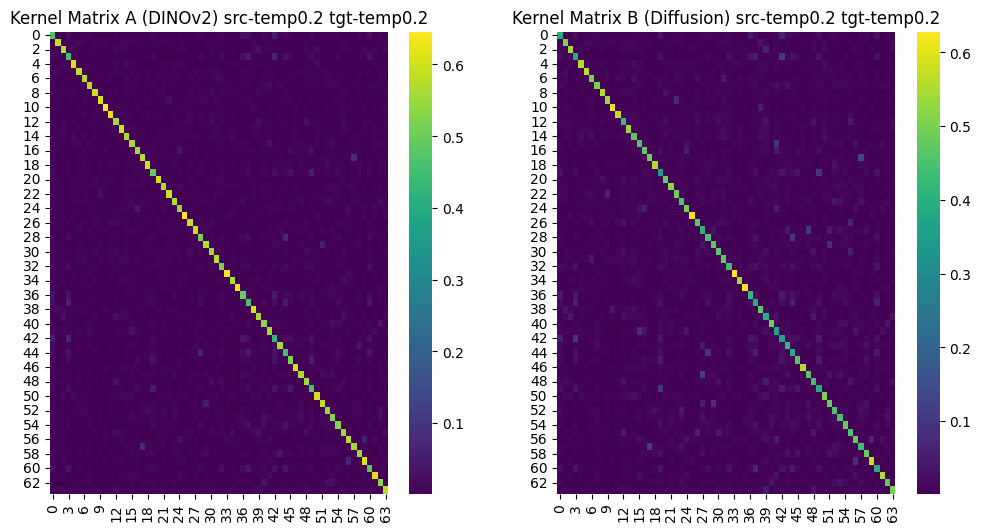

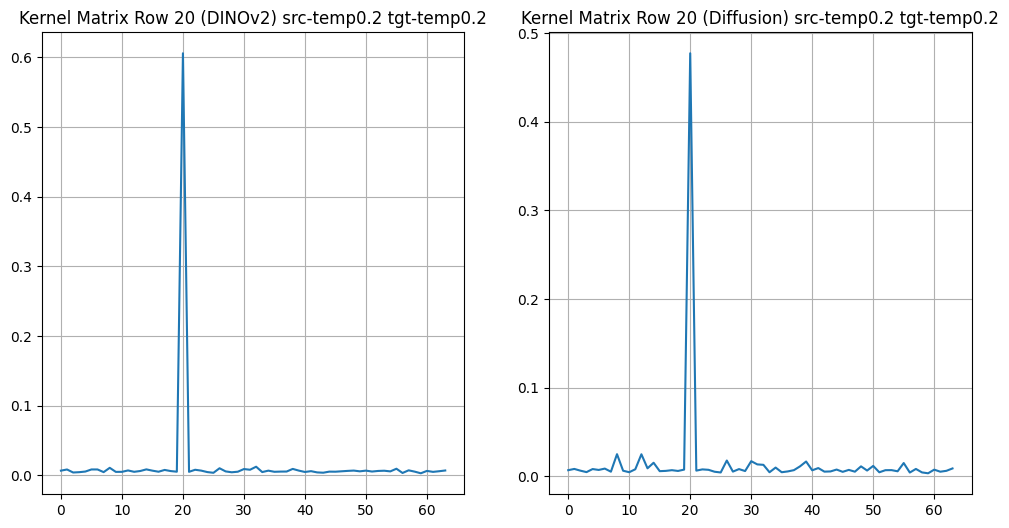

In [11]:
# Analysis here...

# Heatmap of the kernel matrices
plt.figure(figsize=(12, 6))
plt.subplot(121)
sns.heatmap(kernel_matrices_A[0].cpu().numpy(), cmap='viridis', cbar=True)
plt.title(f"Kernel Matrix A (DINOv2) src-temp{args.s2s_src_temp} tgt-temp{args.s2s_tgt_temp}")
plt.subplot(122)
sns.heatmap(kernel_matrices_B[0].cpu().numpy(), cmap='viridis', cbar=True)
plt.title(f"Kernel Matrix B (Diffusion) src-temp{args.s2s_src_temp} tgt-temp{args.s2s_tgt_temp}")
plt.show()

# Row distributions (probability)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.plot(kernel_matrices_A[0][20].cpu().numpy())
plt.title(f"Kernel Matrix Row 20 (DINOv2) src-temp{args.s2s_src_temp} tgt-temp{args.s2s_tgt_temp}")
plt.grid()
plt.subplot(122)
plt.plot(kernel_matrices_B[0][20].cpu().numpy())
plt.title(f"Kernel Matrix Row 20 (Diffusion) src-temp{args.s2s_src_temp} tgt-temp{args.s2s_tgt_temp}")
plt.grid()
plt.show()


In [12]:
# Simulate 64x256 kernel matrix
gpu_id = 2

kernel_alignment_loss = 0.0
kernel_matrices_A = []
kernel_matrices_B = []

for fs_tilde_layer, fs_tilde_g in zip(fs_tilde[gpu_id], fs_tilde_gather):
    for i, (z, z_g, f_tilde, f_tilde_g) in enumerate(zip(zs[gpu_id], zs_gather, fs_tilde_layer, fs_tilde_g)):
        curr_kernel_alignment_loss, kernel_matrix_A, kernel_matrix_B = sample2sample_kernel_alignment_score_jsd(
            feats_A=z,  # [B, N, D]
            feats_B=f_tilde, # [B, N, D]
            feats_A_=z_g,       # [B x n_gpus, N, D]
            feats_B_=f_tilde_g,  # [B x n_gpus, N, D]
            src_temp=args.s2s_src_temp,
            tgt_temp=args.s2s_tgt_temp,
            detach_grad=False,
        )
        kernel_alignment_loss -= curr_kernel_alignment_loss
        kernel_matrices_A.append(kernel_matrix_A)
        kernel_matrices_B.append(kernel_matrix_B)

print(kernel_alignment_loss.item())

-0.9807408452033997


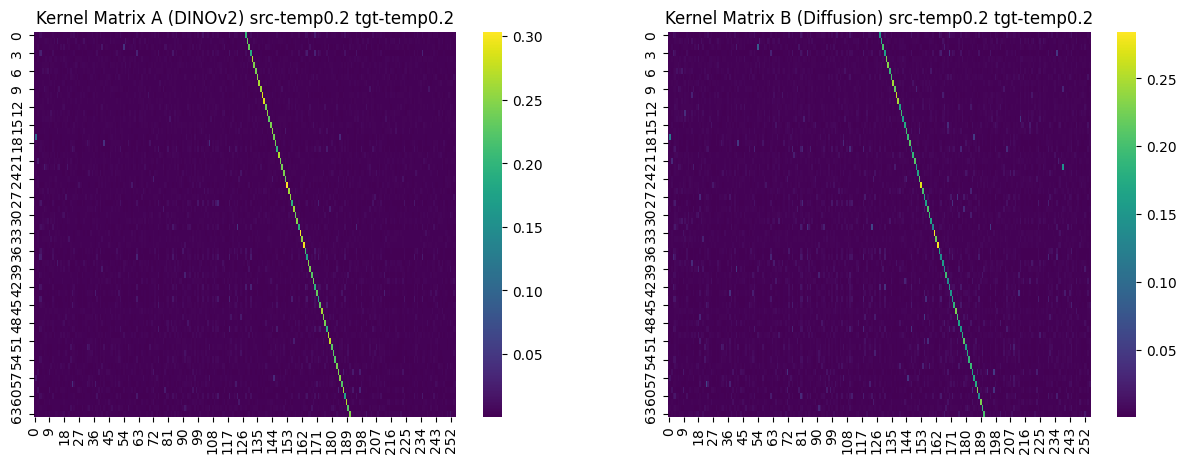

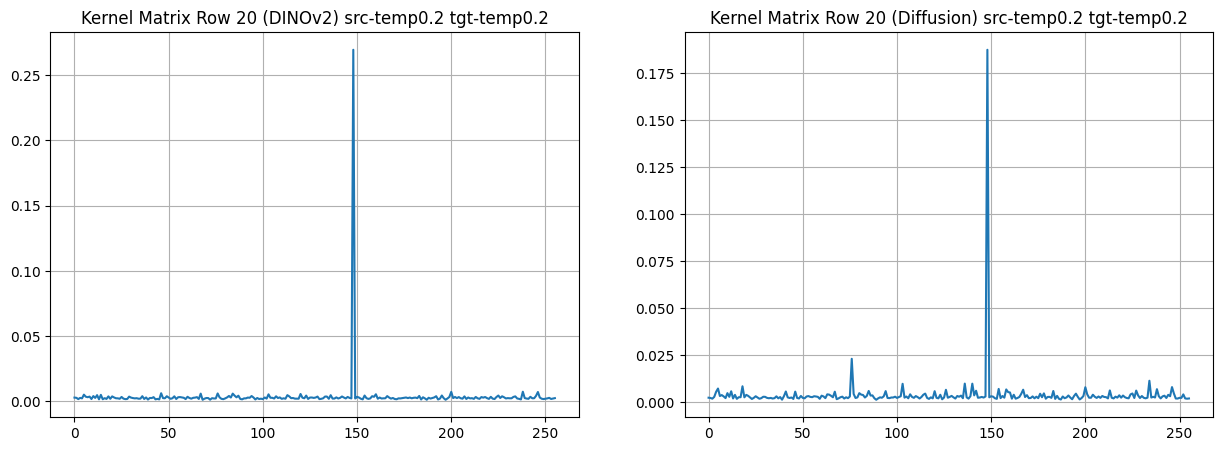

In [13]:
# Analysis here...

# Heatmap of the kernel matrices
plt.figure(figsize=(15, 5))
plt.subplot(121)
sns.heatmap(kernel_matrices_A[0].cpu().numpy(), cmap='viridis', cbar=True)
plt.title(f"Kernel Matrix A (DINOv2) src-temp{args.s2s_src_temp} tgt-temp{args.s2s_tgt_temp}")
plt.subplot(122)
sns.heatmap(kernel_matrices_B[0].cpu().numpy(), cmap='viridis', cbar=True)
plt.title(f"Kernel Matrix B (Diffusion) src-temp{args.s2s_src_temp} tgt-temp{args.s2s_tgt_temp}")
plt.show()

# Row distributions (probability)
plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.plot(kernel_matrices_A[0][20].cpu().numpy())
plt.title(f"Kernel Matrix Row 20 (DINOv2) src-temp{args.s2s_src_temp} tgt-temp{args.s2s_tgt_temp}")
plt.grid()
plt.subplot(122)
plt.plot(kernel_matrices_B[0][20].cpu().numpy())
plt.title(f"Kernel Matrix Row 20 (Diffusion) src-temp{args.s2s_src_temp} tgt-temp{args.s2s_tgt_temp}")
plt.grid()
plt.show()
